In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

In [3]:
# Load the dataset
df = pd.read_csv('merged_essays.csv')

In [2]:
prompts= pd.read_csv('train_prompts.csv')

In [6]:
prompts

,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


In [8]:
prompts['instructions'][0]

'Write an explanatory essay to inform fellow citizens about the advantages of limiting car usage. Your essay must be based on ideas and information that can be found in the passage set. Manage your time carefully so that you can read the passages; plan your response; write your response; and revise and edit your response. Be sure to use evidence from multiple sources; and avoid overly relying on one source. Your response should be in the form of a multiparagraph essay. Write your essay in the space provided.'

In [9]:
prompts['instructions'][1]

'Write a letter to your state senator in which you argue in favor of keeping the Electoral College or changing to election by popular vote for the president of the United States. Use the information from the texts in your essay. Manage your time carefully so that you can read the passages; plan your response; write your response; and revise and edit your response. Be sure to include a claim; address counterclaims; use evidence from multiple sources; and avoid overly relying on one source. Your response should be in the form of a multiparagraph essay. Write your response in the space provided.'

In [10]:
prompts['source_text'][0]

'# In German Suburb, Life Goes On Without Cars by Elisabeth Rosenthal\n\n1 VAUBAN, Germany—Residents of this upscale community are suburban pioneers, going where few soccer moms or commuting executives have ever gone before: they have given up their cars.\n\n2 Street parking, driveways and home garages are generally forbidden in this experimental new district on the outskirts of Freiburg, near the French and Swiss borders. Vauban’s streets are completely “car-free”—except the main thoroughfare, where the tram to downtown Freiburg runs, and a few streets on one edge of the community. Car ownership is allowed, but there are only two places to park—large garages at the edge of the development, where a car-owner buys a space, for $40,000, along with a home.\n\n3 As a result, 70 percent of Vauban’s families do not own cars, and 57 percent sold a car to move here. “When I had a car I was always tense. I’m much happier this way,” said Heidrun Walter, a media trainer and mother of two, as she 

In [11]:
prompts['source_text'][1]

"# What Is the Electoral College? by the Office of the Federal Register\n\n1 The Electoral College is a process, not a place. The founding fathers established it in the Constitution as a compromise between election of the President by a vote in Congress and election of the President by a popular vote of qualified citizens.\n\n2 The Electoral College process consists of the selection of the electors, the meeting of the electors where they vote for President and Vice President, and the counting of the electoral votes by Congress.\n\n3 The Electoral College consists of 538 electors. A majority of 270 electoral votes is required to elect the President. Your state’s entitled allotment of electors equals the number of members in its Congressional delegation: one for each member in the House of Representatives plus two for your Senators. . . .\n\n4 Under the 23rd Amendment of the Constitution, the District of Columbia is allocated 3 electors and treated like a state for purposes of the Electo

In [11]:
# Basic preprocessing
# Removing any rows with missing values
df.dropna(inplace=True)
# Remove duplicates based on 'text' column to ensure uniqueness
df.drop_duplicates(subset='text', inplace=True)

In [14]:
df.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [15]:
#Look at a sample essay 
df['text'][0]

'Cars. Cars have been around since they became famous in the 1900s, when Henry Ford created and built the first ModelT. Cars have played a major role in our every day lives since then. But now, people are starting to question if limiting car usage would be a good thing. To me, limiting the use of cars might be a good thing to do.\n\nIn like matter of this, article, "In German Suburb, Life Goes On Without Cars," by Elizabeth Rosenthal states, how automobiles are the linchpin of suburbs, where middle class families from either Shanghai or Chicago tend to make their homes. Experts say how this is a huge impediment to current efforts to reduce greenhouse gas emissions from tailpipe. Passenger cars are responsible for 12 percent of greenhouse gas emissions in Europe...and up to 50 percent in some carintensive areas in the United States. Cars are the main reason for the greenhouse gas emissions because of a lot of people driving them around all the time getting where they need to go. Article

In [16]:
# Text length analysis
df['text_length'] = df['text'].apply(len)

# Display basic statistics of text length
print(df['text_length'].describe())

# Distribution of AI-generated vs non-AI-generated texts
print(df['generated'].value_counts())


count    1488.000000
mean     3053.638441
std       987.452659
min       474.000000
25%      2429.750000
50%      2894.500000
75%      3535.750000
max      8436.000000
Name: text_length, dtype: float64
generated
0    1375
1     113
Name: count, dtype: int64


# EDA

### Distribution of text length

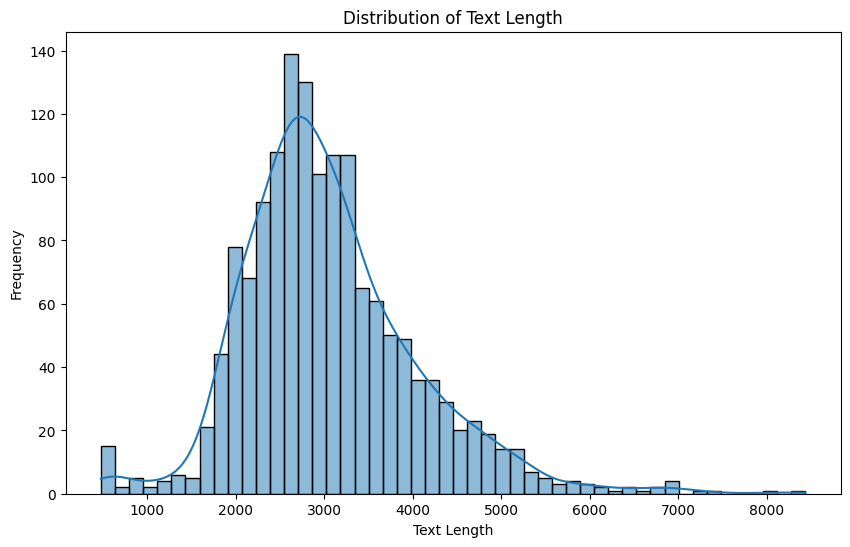

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate text length for each document
df['text_length'] = df['text'].apply(len)

# Plotting the distribution of text lengths
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=50, kde=True)
plt.title('Distribution of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()


## Distribution of Classes

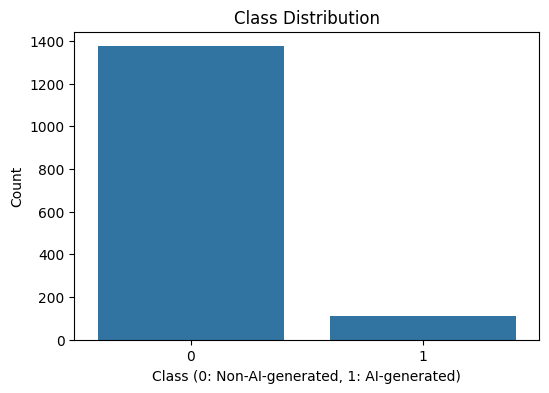

In [22]:
# Plotting the distribution of classes
plt.figure(figsize=(6, 4))
sns.countplot(x='generated', data=df)
plt.title('Class Distribution')
plt.xlabel('Class (0: Non-AI-generated, 1: AI-generated)')
plt.ylabel('Count')
plt.show()


## Word Frequency

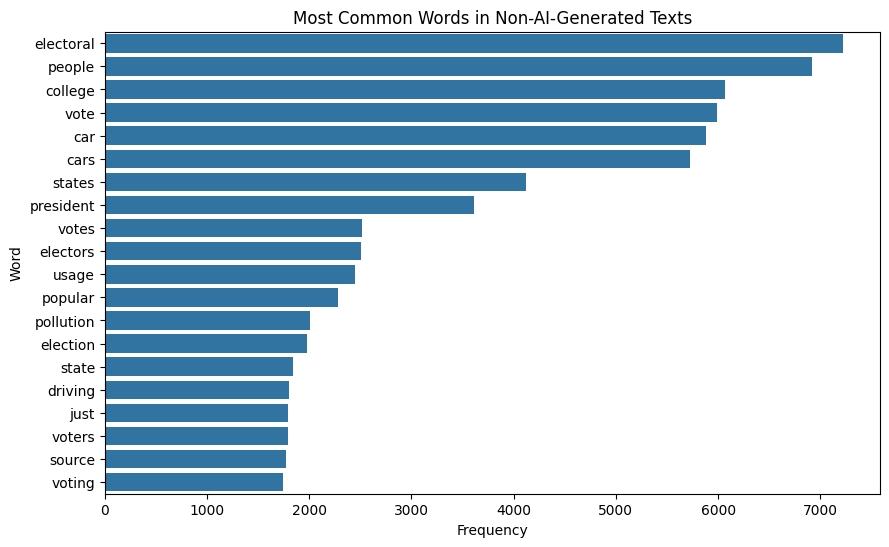

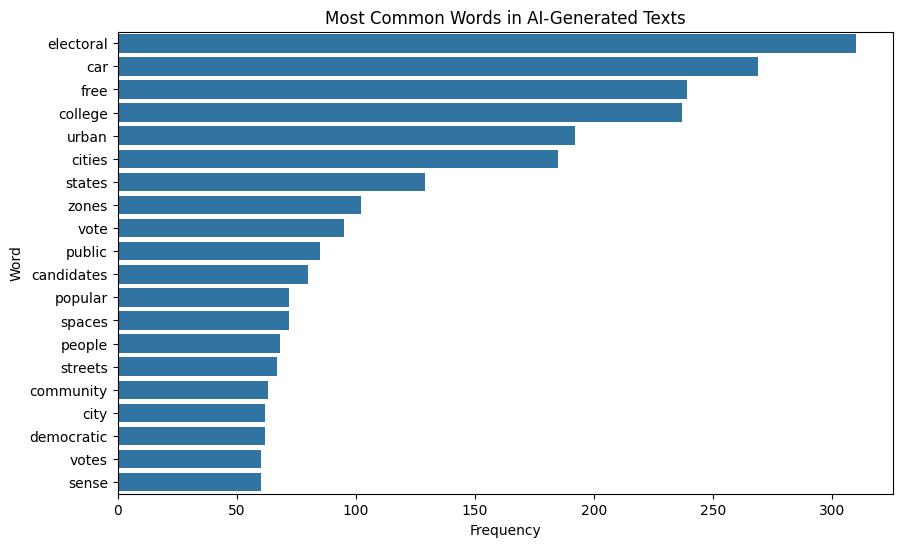

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import pandas as pd

def plot_most_common_words(texts, n=20, title="Most Common Words"):
    """
    Plots the most common n words in the given texts.
    """
    # Vectorizing the text
    vec = CountVectorizer(stop_words='english').fit(texts)
    bag_of_words = vec.transform(texts)
    sum_words = bag_of_words.sum(axis=0)
    
    # Counting the word frequencies
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    
    # Converting to DataFrame for easy plotting
    common_words = pd.DataFrame(words_freq[:n], columns=['Word', 'Frequency'])
    
    # Plotting
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Frequency', y='Word', data=common_words)
    plt.title(title)
    plt.xlabel('Frequency')
    plt.ylabel('Word')
    plt.show()

# Separate the texts by class
texts_non_ai = df[df['generated'] == 0]['text']
texts_ai = df[df['generated'] == 1]['text']

# Plot for Non-AI-Generated Texts
plot_most_common_words(texts_non_ai, n=20, title="Most Common Words in Non-AI-Generated Texts")

# Plot for AI-Generated Texts
plot_most_common_words(texts_ai, n=20, title="Most Common Words in AI-Generated Texts")


##  Word Clouds


In [27]:
pip install wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.8/172.8 kB 2.9 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


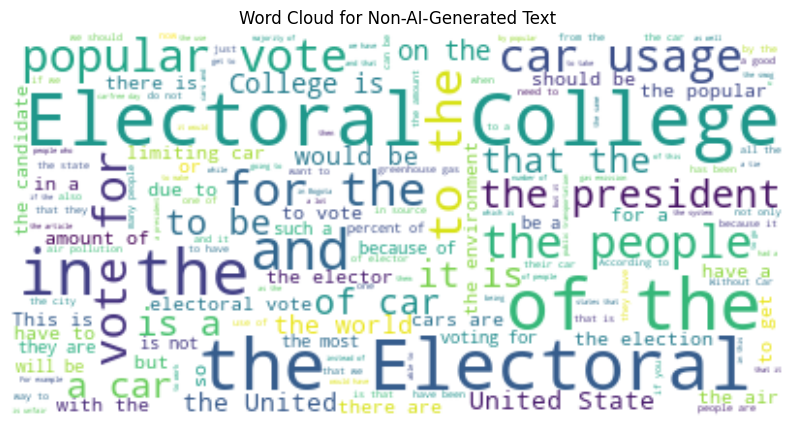

In [28]:
from wordcloud import WordCloud

# Generate a word cloud image for non-AI-generated text
non_ai_text = " ".join(text for text in df[df['generated'] == 0]['text'])
wordcloud_non_ai = WordCloud(stopwords='english', background_color="white").generate(non_ai_text)

# Display the generated image
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_non_ai, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud for Non-AI-Generated Text')
plt.show()


## Parts-of-Speech

In [29]:
pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 4.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 5.6 MB/s eta 0:00:00ta 0:00:01
Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jaeswang/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /Users/jaeswang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


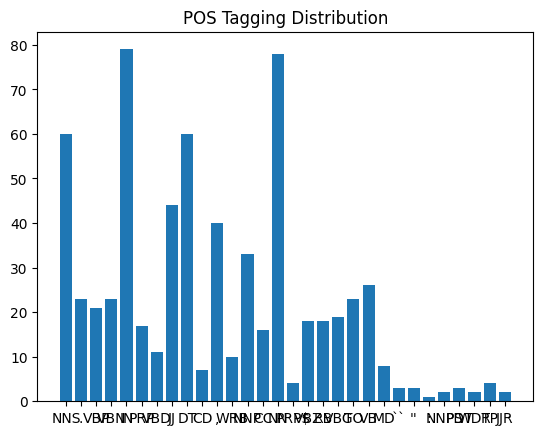

In [30]:
import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from collections import Counter

nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

# Example for one document, you can scale this for more
text = df.iloc[0]['text']
tokens = word_tokenize(text)
tags = pos_tag(tokens)
counts = Counter(tag for word, tag in tags)

# Visualizing the distribution of parts of speech
plt.bar(counts.keys(), counts.values())
plt.title('POS Tagging Distribution')
plt.show()


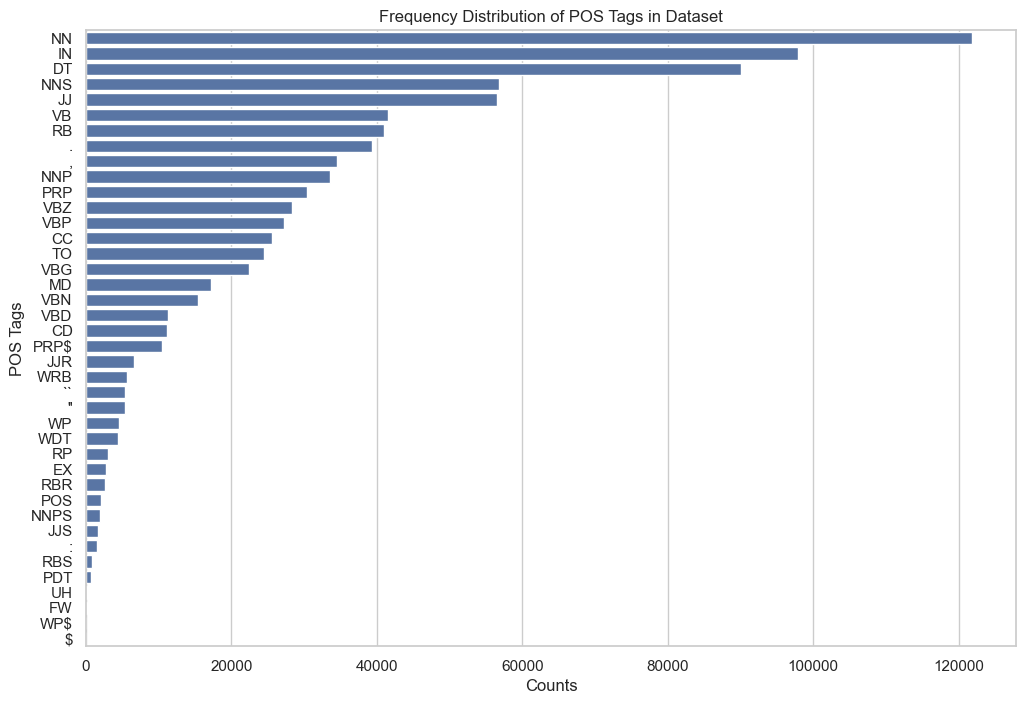

In [40]:
# Example function to get POS counts for a single document
def get_pos_counts(text):
    tokens = word_tokenize(text)
    tagged_tokens = pos_tag(tokens)
    pos_counts = nltk.FreqDist(tag for (word, tag) in tagged_tokens)
    return pos_counts

# Apply the function to each document in your DataFrame (assuming 'text' column)
df['pos_counts'] = df['text'].apply(get_pos_counts)
from collections import defaultdict

# Initialize a default dictionary to hold aggregated POS counts
total_pos_counts = defaultdict(int)

# Aggregate POS counts from each document
for index, row in df.iterrows():
    for pos, count in row['pos_counts'].items():
        total_pos_counts[pos] += count

# Convert to a list of tuples and sort by count
sorted_pos_counts = sorted(total_pos_counts.items(), key=lambda x: x[1], reverse=True)
# Extracting POS tags and their counts for plotting
pos_tags, counts = zip(*sorted_pos_counts)
# Corrected call to seaborn's barplot function
plt.figure(figsize=(12, 8))
sns.barplot(x=list(counts), y=list(pos_tags))
plt.xlabel('Counts')
plt.ylabel('POS Tags')
plt.title('Frequency Distribution of POS Tags in Dataset')
plt.show()

In [41]:
df

,id,prompt_id,text,generated,text_length,polarity,pos_counts
0,0059830c,0,Cars. Cars have been around since they became ...,0,3289,0.078961,"{'NNS': 60, '.': 23, 'VBP': 21, 'VBN': 23, 'IN..."
1,005db917,0,Transportation is a large necessity in most co...,0,2738,0.040952,"{'NN': 88, 'VBZ': 16, 'DT': 48, 'JJ': 34, 'IN'..."
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0,4428,0.107667,"{'``': 9, 'NNP': 19, 'POS': 3, 'NN': 142, 'IN'..."
3,940276,0,How often do you ride in a car? Do you drive a...,0,4013,0.063834,"{'WRB': 6, 'RB': 31, 'VBP': 30, 'PRP': 36, 'VB..."
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0,4698,0.119379,"{'NNS': 45, 'VBP': 30, 'DT': 79, 'JJ': 57, 'NN..."
...,...,...,...,...,...,...,...
1483,106,1,The American electoral system is often critici...,1,2244,-0.003337,"{'DT': 48, 'NNP': 1, 'JJ': 32, 'NN': 58, 'VBZ'..."
1484,107,1,"The electoral college, with its red and blue s...",1,1923,0.171703,"{'DT': 40, 'JJ': 30, 'NN': 52, ',': 17, 'IN': ..."
1485,108,1,The American political landscape is often pain...,1,1280,0.051250,"{'DT': 24, 'JJ': 22, 'NN': 30, 'VBZ': 7, 'RB':..."
1486,109,1,"The American heartland, vast and diverse, is o...",1,2057,0.050000,"{'DT': 35, 'JJ': 37, 'NN': 38, ',': 20, 'CC': ..."


## Sentiment Analysis

In [36]:
#Adding Sentiment Analysis to the Data
from textblob import TextBlob

# Calculate sentiment polarity
df['polarity'] = df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)


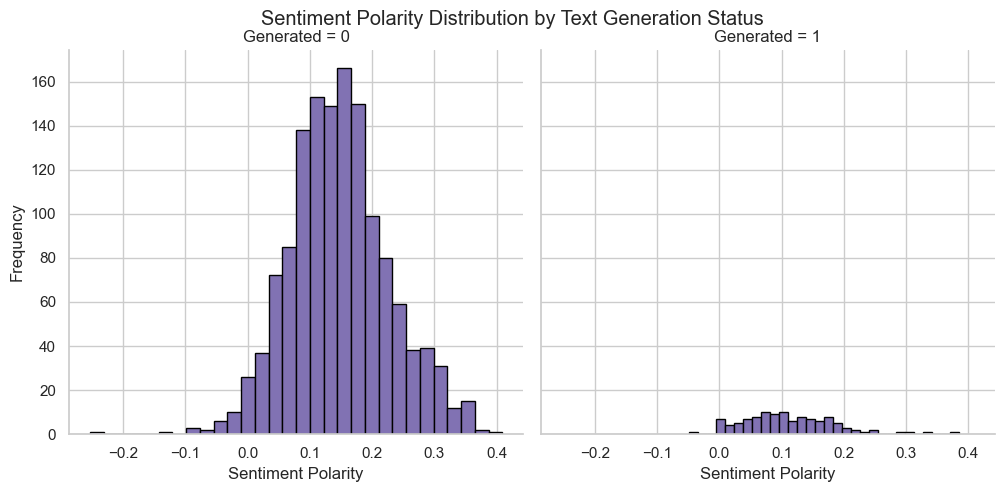

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# Setting the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a FacetGrid to show the distributions of sentiment polarity by 'generated' category
g = sns.FacetGrid(df, col="generated", height=5, aspect=1)
g = g.map(plt.hist, "polarity", bins=30, color="m", edgecolor="black")

# Adding titles and labels
g.set_titles("Generated = {col_name}")
g.set_axis_labels("Sentiment Polarity", "Frequency")
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Sentiment Polarity Distribution by Text Generation Status')

plt.show()


## Topic Modeling

In [34]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Applying LDA
count_vect = CountVectorizer(max_df=0.8, min_df=2, stop_words='english')
doc_term_matrix = count_vect.fit_transform(df['text'])

LDA = LatentDirichletAllocation(n_components=5, random_state=42)
LDA.fit(doc_term_matrix)

# Fetching the 10 most common words for each topic
for i, topic in enumerate(LDA.components_):
    print(f'Top 10 words for topic #{i}:')
    print([count_vect.get_feature_names_out()[index] for index in topic.argsort()[-10:]])
    print('\n')



Top 10 words for topic #0:
['noto', 'voite', 'tohato', 'electooral', 'ao', 'college', 'ito', 'ahe', 'ithe', 'tohe']


Top 10 words for topic #1:
['pollution', 'way', 'air', 'city', 'like', 'day', 'driving', 'just', 'cars', 'car']


Top 10 words for topic #2:
['world', 'use', 'driving', 'air', 'smog', 'limiting', 'pollution', 'usage', 'car', 'cars']


Top 10 words for topic #3:
['voters', 'election', 'popular', 'electors', 'votes', 'states', 'president', 'vote', 'college', 'electoral']


Top 10 words for topic #4:
['ii', 'spaces', 'public', 'zones', 'theat', 'cities', 'urban', 'free', 'car', 'thee']




# Feature Engineering

In [47]:
df.head()

,id,prompt_id,text,generated,text_length,polarity,NNS,.,VBP,VBN,...,JJS,RBR,EX,POS,RBS,WP,UH,FW,$,WP$
0,0059830c,0,Cars. Cars have been around since they became ...,0,3289,0.078961,60.0,23.0,21.0,23.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,005db917,0,Transportation is a large necessity in most co...,0,2738,0.040952,44.0,27.0,12.0,17.0,...,1.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0,4428,0.107667,54.0,48.0,20.0,23.0,...,0.0,5.0,2.0,3.0,2.0,6.0,2.0,0.0,0.0,0.0
3,940276,0,How often do you ride in a car? Do you drive a...,0,4013,0.063834,47.0,48.0,30.0,12.0,...,0.0,0.0,3.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0,4698,0.119379,45.0,48.0,30.0,10.0,...,1.0,2.0,6.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0


In [42]:
# Convert the pos_counts dictionaries into a DataFrame
pos_counts_df = df['pos_counts'].apply(pd.Series)

# Fill NaNs with zeros since a NaN means the tag didn't appear in the text
pos_counts_df = pos_counts_df.fillna(0)

# Now, concatenate this new DataFrame with your original DataFrame
df = pd.concat([df, pos_counts_df], axis=1)

# Drop the original pos_counts column as it's no longer needed
df = df.drop('pos_counts', axis=1)


In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')  # You can adjust 'max_features'

# Fit and transform the 'text' column to obtain TF-IDF features
tfidf_features = tfidf_vectorizer.fit_transform(df['text'])

# Convert to a DataFrame
tfidf_df = pd.DataFrame(tfidf_features.toarray(), columns=tfidf_vectorizer.get_feature_names_out())


In [51]:
# Concatenate the TF-IDF features with the other features
# Make sure the indices align between the DataFrames
combined_df = pd.concat([df.reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)


In [52]:
combined_df

,id,prompt_id,text,generated,text_length,polarity,NNS,.,VBP,VBN,...,woven,written,wrong,wyoming,year,years,yes,york,young,zones
0,0059830c,0,Cars. Cars have been around since they became ...,0,3289,0.078961,60.0,23.0,21.0,23.0,...,0.0,0.0,0.00000,0.0,0.038900,0.0,0.000000,0.000000,0.0,0.000000
1,005db917,0,Transportation is a large necessity in most co...,0,2738,0.040952,44.0,27.0,12.0,17.0,...,0.0,0.0,0.00000,0.0,0.094038,0.0,0.000000,0.000000,0.0,0.080959
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0,4428,0.107667,54.0,48.0,20.0,23.0,...,0.0,0.0,0.00000,0.0,0.000000,0.0,0.097682,0.000000,0.0,0.000000
3,940276,0,How often do you ride in a car? Do you drive a...,0,4013,0.063834,47.0,48.0,30.0,12.0,...,0.0,0.0,0.00000,0.0,0.000000,0.0,0.000000,0.059952,0.0,0.000000
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0,4698,0.119379,45.0,48.0,30.0,10.0,...,0.0,0.0,0.02978,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1483,106,1,The American electoral system is often critici...,1,2244,-0.003337,45.0,17.0,5.0,3.0,...,0.0,0.0,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
1484,107,1,"The electoral college, with its red and blue s...",1,1923,0.171703,21.0,14.0,4.0,4.0,...,0.0,0.0,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
1485,108,1,The American political landscape is often pain...,1,1280,0.051250,24.0,10.0,3.0,3.0,...,0.0,0.0,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
1486,109,1,"The American heartland, vast and diverse, is o...",1,2057,0.050000,36.0,17.0,11.0,5.0,...,0.0,0.0,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000


# Logistic Regression

In [63]:
from sklearn.model_selection import train_test_split

# Define your feature set and target variable
X = combined_df.drop(['id', 'prompt_id', 'text', 'generated'], axis=1)  # Drop non-feature columns
y = combined_df['generated']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [64]:
# After you've created your train and test splits
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

#Training set is 80 percent of data and test set is 20 percent of data

X_train shape: (1190, 1042)
X_test shape: (298, 1042)
y_train shape: (1190,)
y_test shape: (298,)


In [65]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Assuming you have loaded your dataset into a DataFrame 'df'
# and it's formatted as in the sample data you provided.

# Define your feature set and target variable
X = df.drop(['id', 'prompt_id', 'text', 'generated'], axis=1)  # Exclude non-feature and target columns
y = df['generated']

# Initialize the Logistic Regression model
logreg = LogisticRegression(max_iter=1000)  # Increasing max_iter for convergence

# Fit the model on the training data
logreg.fit(X_train, y_train)

# Predict on the testing data
y_pred = logreg.predict(X_test)

# Print out the shapes of the training and test sets
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



X_train shape: (1190, 1042)
X_test shape: (298, 1042)
y_train shape: (1190,)
y_test shape: (298,)
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       277
           1       1.00      1.00      1.00        21

    accuracy                           1.00       298
   macro avg       1.00      1.00      1.00       298
weighted avg       1.00      1.00      1.00       298

Confusion Matrix:
 [[277   0]
 [  0  21]]


/Users/jaeswang/opt/anaconda3/envs/base2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Simplified

In [66]:
# Selecting a simplified set of features
simplified_features = df[['text_length', 'polarity']]
target = df['generated']


In [67]:
# Split the simplified feature set and the target variable
X_train_simplified, X_test_simplified, y_train, y_test = train_test_split(
    simplified_features, target, test_size=0.2, random_state=42)


In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Initialize and train the logistic regression model
logreg_simplified = LogisticRegression()
logreg_simplified.fit(X_train_simplified, y_train)

# Predict on the test set
y_pred_simplified = logreg_simplified.predict(X_test_simplified)

print(f'X_train_simplified shape: {X_train_simplified.shape}')
print(f'X_test_simplified shape: {X_test_simplified.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')


# Evaluate the model
print("Classification Report (Simplified Features):\n", classification_report(y_test, y_pred_simplified))
print("Confusion Matrix (Simplified Features):\n", confusion_matrix(y_test, y_pred_simplified))


X_train_simplified shape: (1190, 2)
X_test_simplified shape: (298, 2)
y_train shape: (1190,)
y_test shape: (298,)
Classification Report (Simplified Features):
               precision    recall  f1-score   support

           0       0.96      0.99      0.98       277
           1       0.85      0.52      0.65        21

    accuracy                           0.96       298
   macro avg       0.91      0.76      0.81       298
weighted avg       0.96      0.96      0.96       298

Confusion Matrix (Simplified Features):
 [[275   2]
 [ 10  11]]


# TF-IDF Vectorizer

TF-IDF stands for Term Frequency-Inverse Document Frequency. It's a numerical statistic intended to reflect how important a word is to a document in a collection or corpus. Here's a breakdown:

### Term Frequency (TF): 
This measures how frequently a term occurs in a document. Since documents can vary in length, it's often the term count in a document divided by the total number of terms in the document, which normalizes the count.

### Inverse Document Frequency (IDF): 
This measures how important a term is. While computing TF, all terms are considered equally important. However, certain terms, like "is", "of", and "that", may appear a lot of times but have little importance. Thus, we need to weigh down the frequent terms while scaling up the rare ones. IDF is calculated as the logarithm of the number of documents divided by the number of documents that contain the term.

# TF-IDF: 
It's the product of TF and IDF, giving us a weight indicating the importance of a word in a document relative to a corpus. The higher the TF-IDF value, the more important a word is to a document in the corpus.

In [18]:
# Initialize the Logistic Regression model
log_reg = LogisticRegression()

# Train the model
log_reg.fit(X_train, y_train)

# Predict on the testing set
y_pred = log_reg.predict(X_test)

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       277
           1       1.00      0.71      0.83        21

    accuracy                           0.98       298
   macro avg       0.99      0.86      0.91       298
weighted avg       0.98      0.98      0.98       298

Accuracy Score: 0.9798657718120806


## Simple Logistic Regression Model Analysis

We can see very high accuracy scores across the board with our simple logistic regression model. Taking into consideration the extremely large class imbalance, it is clear that this high accuracy is a false indicator of the model's true performance. Which is why we need to use a dataset that is much more balanced in terms of non ai generated texts and ai generated texts when workin gon more advanced models
